<a href="https://colab.research.google.com/github/StefanMalv/INFO284_SemesterOppgave_2025V/blob/main/Oppgave1/NYESTE_VERSJON_OPPGAVE1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()  # Manually upload "Hotel_Reviews.csv"

Saving Hotel_Reviews.csv to Hotel_Reviews.csv


We begin by uploading the 'hotel_reviews.csv' file manually via Google Colab. This step is required to access the review dataset.

In [107]:
!pip install nltk


In this section, we import the necessary libraries to support all steps in the workflow: preprocessing, vectorization, model training, and evaluation. Each library plays a critical role in handling different aspects of the process:

Preprocessing: pandas and sklearn assist in data cleaning, transforming raw text data, and preparing it for the next steps.

Vectorization: Tools like TfidfVectorizer are used to convert the text data into a numerical format, making it suitable for model training.

Model Training: scikit-learn or tensorflow, allow us to train and evaluate the model.

In [108]:
### Importing Libraries

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Recall
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [109]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

We download essential linguistic resources. These are required for effective text normalization later on.


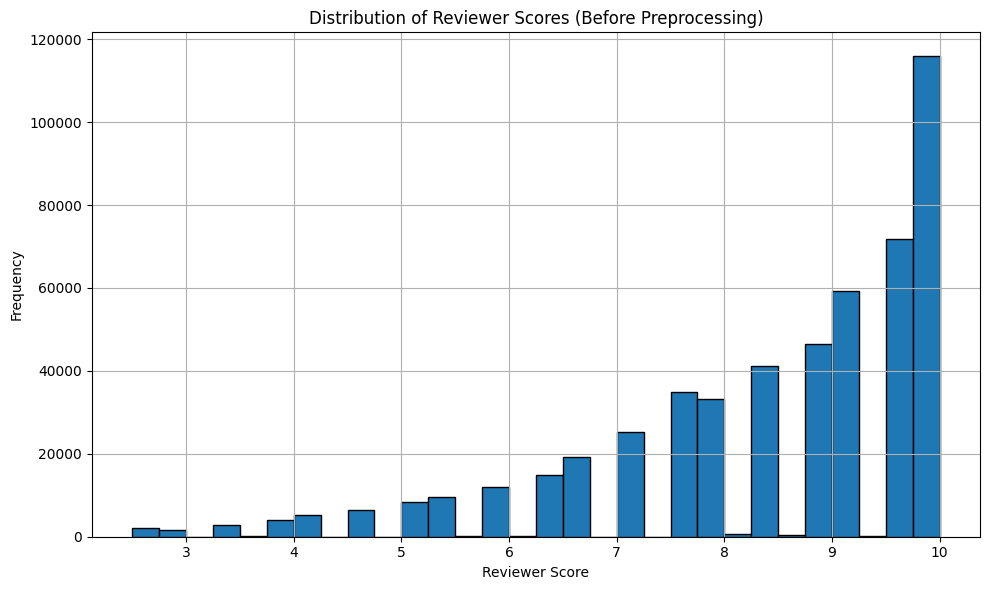

In [110]:
#Load the dataframe before using it
df = pd.read_csv("Hotel_Reviews.csv")

plt.figure(figsize=(10, 6))
df["Reviewer_Score"].hist(bins=30, edgecolor="black")
plt.title("Distribution of Reviewer Scores (Before Preprocessing)")
plt.xlabel("Reviewer Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

To visualize the distribution of the 'Reviewer_Score'. This step helps us understand how user scores are distributed before any transformations, and we get insight to choose meaningful variables later on. f.eks most scores are above 8, witch is important insight to difine "bad rewies"



In [111]:
#Load and combine reviews
df = pd.read_csv("Hotel_Reviews.csv")
df["Positive_Review"] = df["Positive_Review"].astype(str)
df["Negative_Review"] = df["Negative_Review"].astype(str)
df["reviews"] = df["Positive_Review"] + " " + df["Negative_Review"]

Here we casting both the 'Positive_review' and 'Negative_review' columns to strings and then concatenate them into a single `review' column. Combining both perspectives into one sentence helps the model learn the overall sentiment of the user experience.
(spørsmål: er det dumt å ha stor bokstav på Posetiv og Negativ og så liten på reviews)


In [112]:
# Filter for a good review (score > 8)
good_review_row = df[df["Reviewer_Score"] > 8].iloc[0]

# Filter for a bad review (score < 5)
bad_review_row = df[df["Reviewer_Score"] < 5].iloc[0]

# Display the reviews
print("\n=== Example of a Good Review (Score > 8) ===\n")
print(good_review_row["reviews"])

print("\n=== Example of a Bad Review (Score < 5) ===\n")
print(bad_review_row["reviews"])


=== Example of a Good Review (Score > 8) ===

 Good location Set in a lovely park friendly staff Food high quality We Oth enjoyed the breakfast   Apart from the price for the brekfast Everything very good

=== Example of a Bad Review (Score < 5) ===

 Only the park outside of the hotel was beautiful   I am so angry that i made this post available via all possible sites i use when planing my trips so no one will make the mistake of booking this place I made my booking via booking com We stayed for 6 nights in this hotel from 11 to 17 July Upon arrival we were placed in a small room on the 2nd floor of the hotel It turned out that this was not the room we booked I had specially reserved the 2 level duplex room so that we would have a big windows and high ceilings The room itself was ok if you don t mind the broken window that can not be closed hello rain and a mini fridge that contained some sort of a bio weapon at least i guessed so by the smell of it I intimately asked to change the r

EKSEMPEL AV HVORDAN EV REVIEW UNDER 5 SER UT OG EN OVER 8 SER UT!
Legg også merke til at det er mange mellomrom, dette fikser vi i data cleaning og processing

In [113]:
# Focus on reviews with Reviewer_Score <= 8
bad_reviews = df[df["Reviewer_Score"] <= 8]

# Count reviews where Negative_Review is not empty and not 'No Negative'
bad_with_negative_info = bad_reviews[~bad_reviews["Negative_Review"].str.lower().str.strip().isin(["no negative", ""])]

# Calculate percentage
total_bad_reviews = len(bad_reviews)
count_with_negative_info = len(bad_with_negative_info)
percent_with_negative_info = (count_with_negative_info / total_bad_reviews) * 100 if total_bad_reviews else 0

print("\n=== Analysis of what we have chosen as Bad Reviews (review score under 8) ===\n")
print(f"Total bad reviews (score <= 8): {total_bad_reviews}")
print(f"Bad reviews with real negative information: {count_with_negative_info}")
print(f"Percentage with negative information: {percent_with_negative_info:.2f}%")



=== Analysis of what we have chosen as Bad Reviews (review score under 8) ===

Total bad reviews (score <= 8): 180597
Bad reviews with real negative information: 167501
Percentage with negative information: 92.75%


In [114]:
#Create label for bad reviews (score <= 8) BEFORE selecting specific columns
#Most scores are above 8, so using 8 as the threshold helps capture truly negative reviews and keeps the classes balanced.
df["Bad_reviews"] = df["Reviewer_Score"].apply(lambda x: 1 if x <= 8 else 0)

We define binary labels in the `Bad_reviews'column, before selcting specific columns:
- 1 indicates a negativ experiense and happens when 'Reviewer_Score' is less or equal to 8
- 0 indictes a posetive experiense
we chose the limit to 8 beacuse, While the scale is from 0 to 10, the scores are skewed toward the higher end. A threshold of 8 captures meaningful negative feedback while maintaining class balance.

The reason we define lables before selecting spesific colums is because at this point, we still have access to the original 'Reviewer_Score', which is necessary to generate the new label. If we had selected only the `reviwes' column too early, we would have lost the score and been unable to create our target label.




In [115]:
#Select the desired columns
df = df[["reviews", "Bad_reviews"]]

We keep only the 'reviews' and the corresponding `Bad_reviews' label for our classification task. This ensures we focus solely on the textual content and sentiment label.


In [116]:
#Basic cleanup: remove placeholder texts, drop missing/duplicate entries
df["reviews"] = (
    df["reviews"]
    .str.replace("No Negative", "", regex=False)
    .str.replace("No Positive", "", regex=False)
    .str.replace(r"\s+", " ", regex=True)
)
df.dropna(subset=["reviews"], inplace=True)
df.drop_duplicates(subset=["reviews"], inplace=True) #Removing duplicate reviews



Before further preprocessing, we remove placeholder phrases like `"No Positive"` and `"No Negative"` that appear in the review texts. These don't carry any actual sentiment and may mislead the model.

We also:
- Remove rows with missing review text (NaNs) if there is any reviwes with no text
- Drop duplicate reviews

These steps reduce noise and ensure we train models on meaningful, unique data. Duplicates can bias models, and missing/placeholder content weakens learning.

(trenger lowkey hjelp til å forklare denne, dette ble vel litt rotete)



In [117]:
#Show removed and kept stopwords
stop_words = set(stopwords.words("english"))
keep_words = {"not", "no", "never"}
filtered_stopwords = sorted(stop_words - keep_words)

print(f"Stopwords used (removed): {len(filtered_stopwords)}")
print(filtered_stopwords)

print("\nStopwords kept (NOT removed):")
print(sorted(keep_words))

Stopwords used (removed): 196
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'nor', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan

The cell above shows the stopwords that are removed and kept

In [118]:
#Define cleaning function
def clean_text(text):
    keep_words = {"not", "no", "never"}
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s{2,}", " ", text)
    words = word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    filtered_words = [w for w in words if (w not in stop_words) or (w in keep_words)]
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    return " ".join(lemmatized_words)

We define a function to clean each review with the following steps:

1. Lowercase all text to avoid treating words like "Hotel" and "hotel" as different.
2. Remove punctuation/symbols using regex (we keep only alphabetic characters).
3. Tokenize the sentence into words using NLTK's `word_tokenize'.
4. Remove stopwords (e.g., "the", "is") that don't add sentiment value — Exception: we keep negation words like 'no', 'not', `never', because they can change the meaning based on what words that come next.
5. Lemmatize words to reduce them to base form (e.g., "running" → "run"). This groups similar meanings together.

Cleaning ensures a more compact vocabulary and helps models focus on important patterns in language.


In [119]:
#Apply text cleaning
df["Reviews_clean"] = df["reviews"].apply(clean_text)

We apply the 'clean-text' function to all reviews to generate a new column `Reviews_clean'.
This cleaned version will be used for all model training steps. We keep the original version for comparison and analysis.


In [120]:
#Compute lengths of original and cleaned reviews
df["len_before"] = df["reviews"].str.split().str.len()
df["len_after"] = df["Reviews_clean"].str.split().str.len()

We create two columns to help us quantify the effect of preprocessing and ensures we didn't accidentally remove too much content.


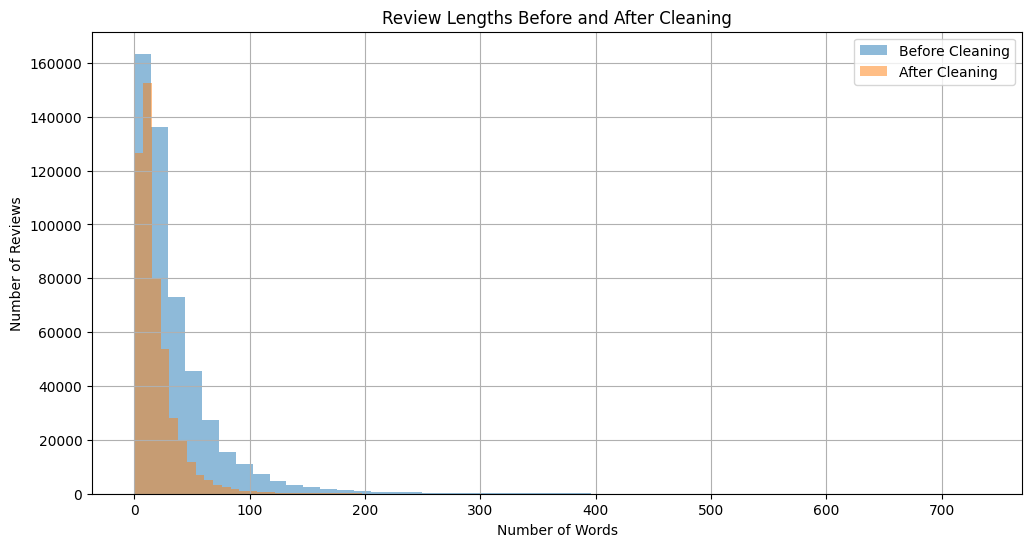

In [121]:
#Plot histograms of review lengths
plt.figure(figsize=(12, 6))

plt.hist(df["len_before"], bins=50, alpha=0.5, label="Before Cleaning")
plt.hist(df["len_after"], bins=50, alpha=0.5, label="After Cleaning")

plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.title("Review Lengths Before and After Cleaning")
plt.legend()
plt.grid(True)
plt.show()

We plot histograms showing the number of words before and after cleaning. This lets us see whether the cleaning drastically shortened the text and understand review length distribution (e.g., if we need to cap input length for neural networks later)
We can use this information to choose padding lengths and detect outliers.


In [122]:
#Final train-test split
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["Bad_reviews"]
)

We split the dataset into training (80%) and testing (20%) sets using stratified sampling based on the `Bad_reviews' label. We use stratify as it ensures both train and test sets preserve the same class balance (positive/negative).

The reason for splitting the data now is to avoid any data leakage by ensuring that all preprocessing or model training happens only on the training set.


In [123]:
#Display sample output
train_df.head()

,reviews,Bad_reviews,Reviews_clean,len_before,len_after
310980,Great rooms design breakfast,0,great room design breakfast,4,4
369391,Liked how quiet it was on the 6th floor Close...,0,liked quiet th floor close hard rock many good...,30,15
199145,Break fast is in Jamie s attached to the hote...,0,break fast jamie attached hotel could coffee m...,52,26
273513,central location the bed was Rock hard me and...,1,central location bed rock hard partner hardly ...,20,11
363641,This is a renovated hotel with tiny modern ro...,0,renovated hotel tiny modern room affordable pr...,63,37


In [124]:
print("Shape of the training data:", train_df.shape)
print("Shape of the testing data:", test_df.shape)
print("\nFirst 5 rows of the training data:")
print(train_df.head())


Shape of the training data: (398187, 5)
Shape of the testing data: (99547, 5)

First 5 rows of the training data:
                                                  reviews  Bad_reviews  \
310980                      Great rooms design breakfast             0   
369391   Liked how quiet it was on the 6th floor Close...            0   
199145   Break fast is in Jamie s attached to the hote...            0   
273513   central location the bed was Rock hard me and...            1   
363641   This is a renovated hotel with tiny modern ro...            0   

                                            Reviews_clean  len_before  \
310980                        great room design breakfast           4   
369391  liked quiet th floor close hard rock many good...          30   
199145  break fast jamie attached hotel could coffee m...          52   
273513  central location bed rock hard partner hardly ...          20   
363641  renovated hotel tiny modern room affordable pr...          63   

  

In [125]:
print("\nInformation about the training data:")
print(train_df.info())
print("\nDescriptive statistics of the training data:")
print(train_df.describe())


Information about the training data:
<class 'pandas.core.frame.DataFrame'>
Index: 398187 entries, 310980 to 442491
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   reviews        398187 non-null  object
 1   Bad_reviews    398187 non-null  int64 
 2   Reviews_clean  398187 non-null  object
 3   len_before     398187 non-null  int64 
 4   len_after      398187 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 18.2+ MB
None

Descriptive statistics of the training data:
         Bad_reviews     len_before      len_after
count  398187.000000  398187.000000  398187.000000
mean        0.353776      34.810237      19.244106
std         0.478141      38.825926      19.279757
min         0.000000       0.000000       0.000000
25%         0.000000      11.000000       7.000000
50%         0.000000      23.000000      14.000000
75%         1.000000      44.000000      24.000000
max         1.000000     733.00000

In [126]:
# TF-IDF Vectorization with bigrams
# Justification for limit: 10000 features allow capturing relevant patterns without excessive computation.
# With 10000, we reduce the chance of overfitting since this is a large dataset.
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["Reviews_clean"])
X_test_tfidf = tfidf_vectorizer.transform(test_df["Reviews_clean"])

We use `TfidfVectorizer' to convert the cleaned review text into numerical feature vectors. Limiting the 'max-features' to 10000 to reduce memory issues and overfitting since this is a relatively large dataset and 10000 features allow capturing relevant patterns without excessive computation.
'ngram_range=(1, 2)' Includes both unigrams (single words) and bigrams (2-word combinations). Bigrams allow the model to learn important phrases like “not good” or “very clean”.



In [127]:
y_train = train_df["Bad_reviews"]
y_test = test_df["Bad_reviews"]

We store the binary target values ('Bad_reviews) in 'y_train' and `y_test'.

This step keeps inputs ('X') and labels ('y') separate, which is standard practice for training and evaluation.


In [128]:
# Logistic Regression Model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

We train a `LogisticRegression' model on the TF-IDF features.

The reason for choosing logistic regression as one of the models its because it’s a strong and interpretable baseline for binary classification. The model is fast to train, and handles high-dimensional text data well. And also works well when features are transformed with TF-IDF.

We increase `max_iter=1000' to ensure convergence, as text models often require more iterations.


In [129]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f"--- {model_name} Evaluation ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
#    print("F1 Score:", f1_score(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

evaluate_model(lr_model, X_test_tfidf, y_test, "Logistic Regression (TF-IDF)")

--- Logistic Regression (TF-IDF) Evaluation ---
Accuracy: 0.806342732578581
Precision: 0.7560152912075556
Recall: 0.6682568077916915
Confusion Matrix:
[[56735  7595]
 [11683 23534]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85     64330
           1       0.76      0.67      0.71     35217

    accuracy                           0.81     99547
   macro avg       0.79      0.78      0.78     99547
weighted avg       0.80      0.81      0.80     99547



We define a reusable `evaluate_model()' function to compute:
- Accuracy
- Precision
- Recall
- Confusion Matrix
- Classification Report

Precision is important here because we want to avoid falsely labeling positive reviews as negative (false positives). Recall ensures we don’t miss many bad reviews. And F1-score balances both
(spørsmål: hvorfor er f1-scre kommentert ut)

In [130]:
# Train and Evaluate Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
evaluate_model(nb_model, X_test_tfidf, y_test, "Naive Bayes (TF-IDF)")

--- Naive Bayes (TF-IDF) Evaluation ---
Accuracy: 0.7920580228434809
Precision: 0.7377419671808981
Recall: 0.6395774767867791
Confusion Matrix:
[[56323  8007]
 [12693 22524]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.84     64330
           1       0.74      0.64      0.69     35217

    accuracy                           0.79     99547
   macro avg       0.78      0.76      0.76     99547
weighted avg       0.79      0.79      0.79     99547



We train a `MultinomialNB' model using the same TF-IDF features.

The reason for choosing a Naive Bayes Model is because its widely used for text classification tasks. Very fast and efficient for high-dimensional sparse data like TF-IDF. And often performs surprisingly well as a baseline.

Evaluation helps us compare performance against Logistic Regression.


In [131]:
# Train and Evaluate Decision Tree Model
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42) #Max depth added to cap training time and to avoid overfitting.
# Based on previous evaluation, deeper trees (e.g., 30) overfit and reduce recall significantly
dt_model.fit(X_train_tfidf, y_train)
evaluate_model(dt_model, X_test_tfidf, y_test, "Decision Tree (TF-IDF)")

--- Decision Tree (TF-IDF) Evaluation ---
Accuracy: 0.7200819713301254
Precision: 0.6527212297465725
Recall: 0.44611977170116707
Confusion Matrix:
[[55971  8359]
 [19506 15711]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.87      0.80     64330
           1       0.65      0.45      0.53     35217

    accuracy                           0.72     99547
   macro avg       0.70      0.66      0.67     99547
weighted avg       0.71      0.72      0.70     99547



We train a 'DecisionTreeClassifier' with a 'max_depth=10'. Max depth was limited to 10 because deeper trees can overfit easily, especially with sparse, high-dimensional data. During tuning, deeper trees reduced recall, so this cap balances generalization and training time.

Decision trees also offer interpretability, though they often underperform compared to ensemble models on text.


In [132]:
# LSTM Model Training
max_vocab = 10000    # Limit to top 10,000 most frequent tokens to reduce memory & overfitting
max_len = 100        # Pad/truncate reviews to 100 tokens for consistent input shape
embedding_dim = 100  # 100-dim word embeddings balance expressiveness and efficiency

In [133]:
tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>") # Use top 10k words; mark unknown words as <OOV>
tokenizer.fit_on_texts(train_df["Reviews_clean"])             # Build word index from training reviews only

We use a `Tokenizer' from Keras to convert text into integer sequences.
Parameters:
- `num_words=10000': Only keep the 10,000 most frequent words to reduce memory usage and prevent overfitting.
- `oov_token="<OOV>"': Any word not seen during training will be replaced with this token, preventing crashes from unseen test-time tokens.

we have to do these steps because Neural networks (like LSTMs) can't process raw text. They require fixed-length sequences of integers representing word indices.

In [134]:
X_train_seq = tokenizer.texts_to_sequences(train_df["Reviews_clean"])   # Convert words to integer sequences
X_test_seq = tokenizer.texts_to_sequences(test_df["Reviews_clean"])     # Apply same tokenizer to test data
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post') # Pad/truncate to length 100
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

In [135]:
model = Sequential([
    Embedding(10000, 100),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
# Include 'recall' in the metrics list during model compilation
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Recall()])
model.build(input_shape=(None, 100))
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,042,305 (3.98 MB)

 Trainable params: 1,042,305 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

We transform the tokenized sequences to have equal length using `pad_sequences()':

- `maxlen=100': All reviews are padded or truncated to 100 tokens.
- 'padding='post'', `truncating='post'': Ensures that beginning of the sentence remains intact.

the reason for picking 100 tokens:
A histogram of review lengths showed that most cleaned reviews are under 100 words. So, 100 balances:
- Enough context for the model
- Computational efficiency

In [136]:
# Train
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=128, validation_split=0.2)

# Predict
probs = model.predict(X_test_pad)
y_pred = (probs > 0.3).astype(int)

Epoch 1/10
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.6541 - loss: 0.6403 - recall_6: 0.0962 - val_accuracy: 0.6491 - val_loss: 0.6060 - val_recall_6: 0.0149
Epoch 2/10
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.7148 - loss: 0.5532 - recall_6: 0.5284 - val_accuracy: 0.8018 - val_loss: 0.4211 - val_recall_6: 0.6418
Epoch 3/10
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.8061 - loss: 0.4123 - recall_6: 0.6683 - val_accuracy: 0.8064 - val_loss: 0.4119 - val_recall_6: 0.6662
Epoch 4/10
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.8175 - loss: 0.3927 - recall_6: 0.6854 - val_accuracy: 0.8057 - val_loss: 0.4142 - val_recall_6: 0.6887
Epoch 5/10
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.8262 - loss: 0.3761 - recall_6: 0.6978 - val_accuracy: 0.8046 - val_loss: 0.4189 - val_recall_6: 0.6503
Epoch 6/10
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.8342 - loss: 0.3622 - recall_6: 0.7128 - val_accuracy: 0.803

In [137]:
# Evaluation Metrics
y_true = y_test
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

Accuracy: 0.7725
Precision: 0.6488
Recall: 0.7785
F1 Score: 0.7078

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81     64330
           1       0.65      0.78      0.71     35217

    accuracy                           0.77     99547
   macro avg       0.76      0.77      0.76     99547
weighted avg       0.79      0.77      0.78     99547



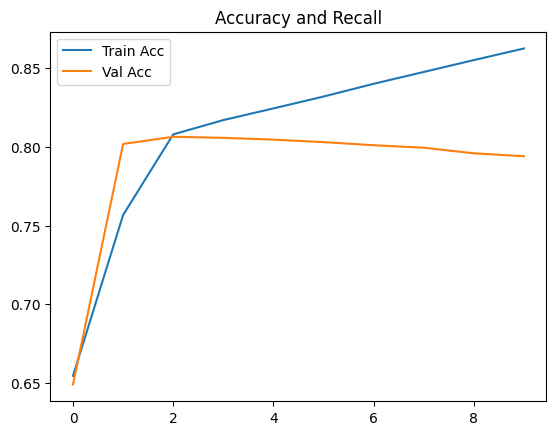

In [138]:
# Plots
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy and Recall')
plt.legend()
plt.show()

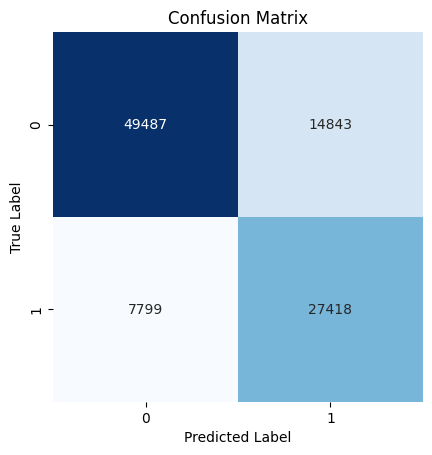

In [141]:
# Heatmap
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()